In [2]:
import networkx as nx

In [3]:
import scipy

In [7]:
import requests
url = "http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/pubid:17446270"

try:
    httpReq = requests.get(url, proxies=None)
except NameError:
    httpReq = requests.get(url)
ans = httpReq.text

In [9]:
psqData = []
for l in ans.split("\n"):
    if l:
        l = l.split("\t")
        if l[0].startswith("uniprotkb:") and l[1].startswith("uniprotkb:"):
            psqData.append( [ l[0].replace("uniprotkb:", ""),  l[1].replace("uniprotkb:", "") ]  + l[2:] )

In [10]:
psqData

[['P0CW72',
  'P0CW72',
  'intact:EBI-2620133|uniprotkb:Q777A5',
  'intact:EBI-2620133|uniprotkb:Q777A5',
  'psi-mi:barf1_ebvg(display_long)|uniprotkb:BARF1(gene name)|psi-mi:BARF1(display_short)|uniprotkb:33 kDa early protein(gene name synonym)|uniprotkb:p33(gene name synonym)',
  'psi-mi:barf1_ebvg(display_long)|uniprotkb:BARF1(gene name)|psi-mi:BARF1(display_short)|uniprotkb:33 kDa early protein(gene name synonym)|uniprotkb:p33(gene name synonym)',
  'psi-mi:"MI:0397"(two hybrid array)',
  'Calderwood et al. (2007)',
  'pubmed:17446270|imex:IM-20435|mint:MINT-6769080',
  'taxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")',
  'taxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")',
  'psi-mi:"MI:0915"(physical association)',
  'psi-mi:"MI:0469"(IntAct)',
  'intact:EBI-2620961|imex:IM-20435-3',
  'author score:+|intact-miscore:0.51'],
 ['P0C704',
  'P14348',
  'intact:EBI-2620975|uniprotkb:Q3KSQ5',
  'intact:EBI-2620158|intact:EBI-9645437|uniprotkb:Q777G5

In [11]:
psqData_EBV_EBV = []
psqData_EBV_Human = []

for x in psqData:
    if "virus" in x[9] and "virus" in x[10]:
        psqData_EBV_EBV.append(x)
    else:
        psqData_EBV_Human.append(x)
print(f"{len(psqData_EBV_Human)}  // {len(psqData_EBV_EBV)}")

171  // 59


In [14]:
G = nx.Graph()
G.add_edge("a", "b")
G.add_edge("a", "c")
for n in G.nodes:
    print(n)

a
b
c


In [15]:
pos = nx.spring_layout(G)
pos

{'a': array([-0.00026951,  0.00111973]),
 'b': array([ 0.24098639, -1.        ]),
 'c': array([-0.24071688,  0.99888027])}

<IPython.core.display.Javascript object>


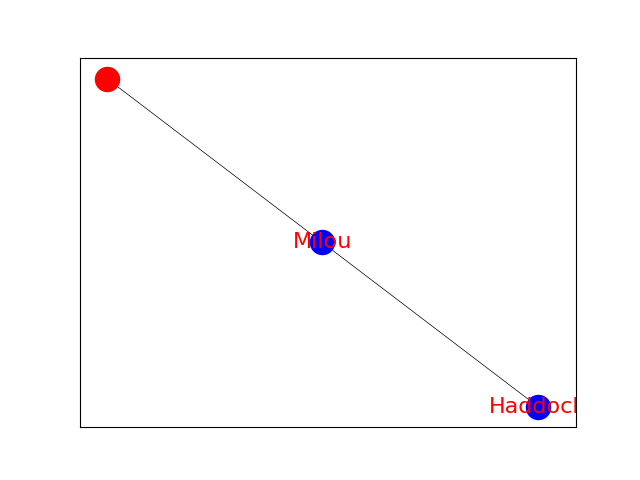

{'a': Text(-0.00026950968802663385, 0.001119727343056518, 'Milou'),
 'b': Text(0.24098638613808102, -1.0, 'Haddock')}

In [19]:
%matplotlib nbagg
import matplotlib.pyplot as plt

nx.draw_networkx_nodes(G, pos, node_color="blue", node_shape="o", nodelist=["a", "b"] )
nx.draw_networkx_nodes(G, pos, node_color="red",  node_shape="o", nodelist=["c"] )
#nx.draw_networkx_labels(G,pos,font_weight=800,font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5)

# Convert names into richer labels and eventually mask some nodes
labelDict = { 
        "a" : "Milou",
        "b" : "Haddock"#, 
#        "c" : "Tryphon"
        }

#Now only add labels to the nodes you require (the hubs in my case)
nx.draw_networkx_labels(G, pos, labelDict, font_size=16, font_color='r')

<IPython.core.display.Javascript object>


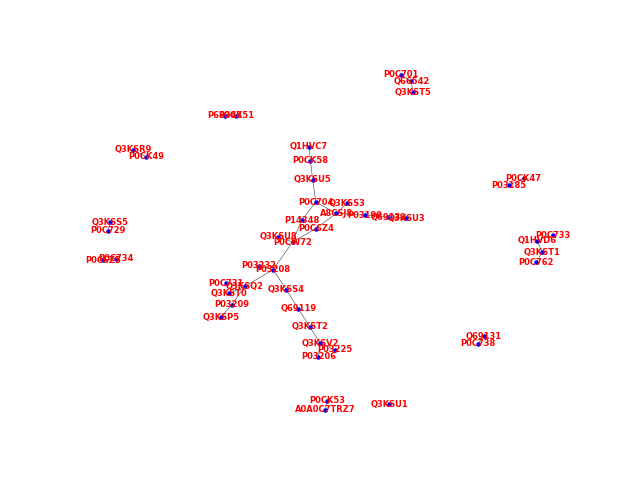

In [41]:
plt.figure()
plt.axis('off')

G = nx.Graph()

EBV_labels = {}

for x in psqData_EBV_EBV:
    G.add_edge(x[0], x[1])
    EBV_labels[ x[0] ] = x[0]
    EBV_labels[ x[1] ] = x[1]
    
#pos=nx.draw(G, with_labels=False)
pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=5, node_color="blue")
nx.draw_networkx_labels(G,pos,EBV_labels,font_size=6,font_weight=600,font_color='r')
nx.draw_networkx_edges(G, pos, width=0.3)


In [27]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree

# Utility functions
# Extracting All go terms relative to provided UNIPROT accessor
def goTerms(xmlEntry):
    ns = '{http://uniprot.org/uniprot}'
    goTerms = xmlEntry.findall(ns +'dbReference[@type="GO"]')
    goTermList = []
    for goT in goTerms:
        gID   = goT.attrib['id']
        gName = goT.find(ns +'property[@type="term"]').attrib['value']
        goTermList.append({"name" : gName, "ID" : gID})
    return goTermList

# Return information about provided UNIPROT accessor as python dictionary
def proteinDict(uniprotID, root):
    ns   = '{http://uniprot.org/uniprot}'

    data = { "accession" : uniprotID,
             "geneName" : None,
             "name" : None,
             "GOterms" : None
           }

    for entry in root.findall(ns+'entry'):
        accessions = entry.findall(ns+"accession")
        for acc in accessions:
            if acc.text == uniprotID: # entry is the node matching provided UNIPROT accessor
                e = entry.find(f"{ns}protein/{ns}recommendedName/{ns}fullName")
                if not e is None:
                    data["name"] = e.text
                e = entry.find(f"{ns}gene/{ns}name")
                if not e is None:
                    data["geneName"] = e.text

                data["GOterms"] = goTerms(entry)
                return data
    raise ValueError(f"{uniprotID} nor found in XML document")



In [40]:
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()
treeQ = proteinDict("Q53Y88", root)
treeQ["geneName"]



'GRN'

<IPython.core.display.Javascript object>


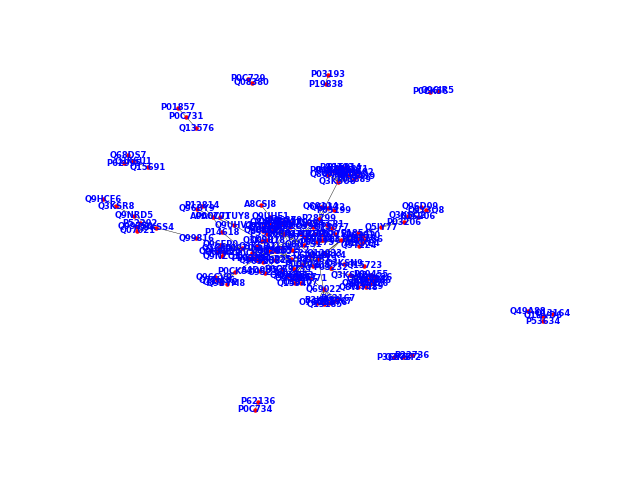

In [45]:
plt.figure()
plt.axis('off')

G3 = nx.Graph()

Human_labels = {}

for x in psqData_EBV_Human:
    G3.add_edge(x[0], x[1])
    Human_labels[ x[0] ] = x[0]
    Human_labels[ x[1] ] = x[1]
    
#pos=nx.draw(G3, with_labels=False)
pos=nx.spring_layout(G3)

nx.draw_networkx_nodes(G3, pos, node_size=5, node_color="red")
nx.draw_networkx_labels(G3,pos,Human_labels,font_size=6,font_weight=600,font_color='b')
nx.draw_networkx_edges(G3, pos, width=0.3)